<a href="https://colab.research.google.com/github/mendoanjoe/sentiment-analysis/blob/main/Sentiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Library

In [13]:
!pip install Sastrawi
!pip install textblob
!pip install transformers

     |████████████████████████████████| 209 kB 5.1 MB/s 
     |████████████████████████████████| 3.4 MB 4.9 MB/s 
     |████████████████████████████████| 596 kB 50.3 MB/s 
     |████████████████████████████████| 3.3 MB 41.4 MB/s 
     |████████████████████████████████| 61 kB 418 kB/s 
     |████████████████████████████████| 895 kB 49.3 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [97]:
import io
import pandas as pd
import matplotlib.pyplot as plt
import json
import string
import re
import nltk
import pickle
import numpy as np

nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from google.colab import drive
from google.colab import files
from wordcloud import WordCloud
from textblob import TextBlob
from transformers import pipeline
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, accuracy_score, f1_score
from sklearn.metrics import roc_curve, auc, classification_report
from sklearn.metrics import confusion_matrix, roc_auc_score, recall_score, precision_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import ComplementNB
from collections import Counter

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# Data sociolla & female daily

## Upload data sociolla.json & femaledaily.json

In [ ]:
data_files = files.upload()

In [ ]:
json_sociolla = json.loads(data_files['sociolla.json'])
json_femaleDaily = json.loads(data_files['femaledaily.json'])

## Normalize json to dataframe

In [ ]:
# https://towardsdatascience.com/how-to-convert-json-into-a-pandas-dataframe-100b2ae1e0d8
df_sociolla = pd.json_normalize(json_sociolla, meta=[['user', 'name'], ['product', 'name']])
df_femaleDaily = pd.json_normalize(json_femaleDaily, meta=[['product', 'packaging_avg'], ['product', 'rating_avg'], ['product', 'total_review'], ['user', 'age_range']])

## Preview dataframe

In [ ]:
df_sociolla.head()

,_id,details,star_texture,star_effectiveness,star_packaging,star_value_for_money,average_rating,created_at,detail,user.name,product.name
0,61b8df2fc6f4e3442ee516fa,"suka banget sama produk ini, gampang dibawa ke...",5,5,5,5,5.0,2021-12-14T18:15:11.866Z,"suka banget sama produk ini, gampang dibawa ke...",Zahra Asyifa,Cica Beat The Sun Powder
1,61b8a6cd8b24ecb6db2e6736,ini aku pertama kali beli produk ini dan aku e...,5,5,5,5,5.0,2021-12-14T14:14:37.221Z,ini aku pertama kali beli produk ini dan aku e...,Nurlela Achmad,Cica Beat The Sun SPF 50 PA ++++
2,61b89df3b7db5e79311918c7,"I love the packaging, the texture, tapi kurang...",4,4,5,5,4.5,2021-12-14T13:36:51.246Z,"I love the packaging, the texture, tapi kurang...",adinda subagio,Cica Beat The Sun SPF 50 PA ++++
3,61b86abe0ba0d9449dae81f1,menyesal kenapa baru tahu ada sunscreen yang b...,5,5,5,5,5.0,2021-12-14T09:58:22.157Z,menyesal kenapa baru tahu ada sunscreen yang b...,Amalia Anggraini,Cica Beat The Sun Powder
4,61b8692ca4eb722150610da8,suka!! bagus bgt buat touch up ditambah lg ini...,5,5,5,4,4.8,2021-12-14T09:51:40.672Z,suka!! bagus bgt buat touch up ditambah lg ini...,Winda Teresia,Cica Beat The Sun Powder


In [ ]:
df_femaleDaily.head()

,rvwr_review_rating,rvwr_review_txt,fullname,review_cur_ori,review_cur_update,prod_item,brand_name,_id.$oid,product.total_review,product.packaging_avg,product.rating_avg,user.age_range
0,5,akhirnya beli produk ini pas banget lagi sale ...,Nadira Ananda Thamrin,IDR,IDR,Cica Beat The Sun Powder,N'pure,619a26b06f6dfb81c79927e2,1452,1,4.9,19 - 24
1,5,"Sun powder dari N'pure ini bagus bangett, gabo...",Oktavia Zuhrotul Hafshah,IDR,IDR,Cica Beat The Sun Powder,N'pure,619a26b06f6dfb81c7992804,1452,1,4.9,18 and Under
2,5,waw sumpah si ini sunscreen yang bener bener b...,wawa,IDR,IDR,Cica Beat The Sun,N'pure,619a26b06f6dfb81c7992833,2952,1,4.9,18 and Under
3,5,N'PURE Cica Beat The Sun Powder ini bener-bene...,Shinta Dwi Asmarani,IDR,IDR,Cica Beat The Sun Powder,N'pure,619a26b06f6dfb81c7992844,1452,1,4.9,25 - 29
4,5,Suka sama teksturnya powder dan aplikatornya b...,Selizar Effendy,IDR,IDR,Cica Beat The Sun Powder,N'pure,619a26b06f6dfb81c79928a8,1452,1,4.9,25 - 29


## Picking datasource

In [ ]:
data_sociolla = df_sociolla[['details']]
data_femaleDaily = df_femaleDaily[['rvwr_review_txt']]

# rename to details
data_femaleDaily.rename(columns = {'rvwr_review_txt':'details'}, inplace = True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


## Preview datasource

In [ ]:
data_sociolla.head()

,details
0,"suka banget sama produk ini, gampang dibawa ke..."
1,ini aku pertama kali beli produk ini dan aku e...
2,"I love the packaging, the texture, tapi kurang..."
3,menyesal kenapa baru tahu ada sunscreen yang b...
4,suka!! bagus bgt buat touch up ditambah lg ini...


In [ ]:
data_femaleDaily.head()

,details
0,akhirnya beli produk ini pas banget lagi sale ...
1,"Sun powder dari N'pure ini bagus bangett, gabo..."
2,waw sumpah si ini sunscreen yang bener bener b...
3,N'PURE Cica Beat The Sun Powder ini bener-bene...
4,Suka sama teksturnya powder dan aplikatornya b...


# Text Preprocessing

## Case folding / to lower case

In [ ]:
def preUsingCaseFolding(text):
  return text.casefold()

In [ ]:
data_sociolla['Pre #1'] = data_sociolla['details'].apply(preUsingCaseFolding)
data_sociolla.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,details,Pre #1
0,"suka banget sama produk ini, gampang dibawa ke...","suka banget sama produk ini, gampang dibawa ke..."
1,ini aku pertama kali beli produk ini dan aku e...,ini aku pertama kali beli produk ini dan aku e...
2,"I love the packaging, the texture, tapi kurang...","i love the packaging, the texture, tapi kurang..."
3,menyesal kenapa baru tahu ada sunscreen yang b...,menyesal kenapa baru tahu ada sunscreen yang b...
4,suka!! bagus bgt buat touch up ditambah lg ini...,suka!! bagus bgt buat touch up ditambah lg ini...


In [ ]:
data_femaleDaily['Pre #1'] = data_femaleDaily['details'].apply(preUsingCaseFolding)
data_femaleDaily.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,details,Pre #1
0,akhirnya beli produk ini pas banget lagi sale ...,akhirnya beli produk ini pas banget lagi sale ...
1,"Sun powder dari N'pure ini bagus bangett, gabo...","sun powder dari n'pure ini bagus bangett, gabo..."
2,waw sumpah si ini sunscreen yang bener bener b...,waw sumpah si ini sunscreen yang bener bener b...
3,N'PURE Cica Beat The Sun Powder ini bener-bene...,n'pure cica beat the sun powder ini bener-bene...
4,Suka sama teksturnya powder dan aplikatornya b...,suka sama teksturnya powder dan aplikatornya b...


## Punctuation removal

In [ ]:
def preUsingPunctuationRemoval(text):
  return text.translate(str.maketrans('', '', string.punctuation))

In [ ]:
data_sociolla['Pre #2'] = data_sociolla['Pre #1'].apply(preUsingPunctuationRemoval)
data_sociolla.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,details,Pre #1,Pre #2
0,"suka banget sama produk ini, gampang dibawa ke...","suka banget sama produk ini, gampang dibawa ke...",suka banget sama produk ini gampang dibawa kem...
1,ini aku pertama kali beli produk ini dan aku e...,ini aku pertama kali beli produk ini dan aku e...,ini aku pertama kali beli produk ini dan aku e...
2,"I love the packaging, the texture, tapi kurang...","i love the packaging, the texture, tapi kurang...",i love the packaging the texture tapi kurang s...
3,menyesal kenapa baru tahu ada sunscreen yang b...,menyesal kenapa baru tahu ada sunscreen yang b...,menyesal kenapa baru tahu ada sunscreen yang b...
4,suka!! bagus bgt buat touch up ditambah lg ini...,suka!! bagus bgt buat touch up ditambah lg ini...,suka bagus bgt buat touch up ditambah lg ini a...


In [ ]:
data_femaleDaily['Pre #2'] = data_femaleDaily['Pre #1'].apply(preUsingPunctuationRemoval)
data_femaleDaily.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,details,Pre #1,Pre #2
0,akhirnya beli produk ini pas banget lagi sale ...,akhirnya beli produk ini pas banget lagi sale ...,akhirnya beli produk ini pas banget lagi sale ...
1,"Sun powder dari N'pure ini bagus bangett, gabo...","sun powder dari n'pure ini bagus bangett, gabo...",sun powder dari npure ini bagus bangett gaboon...
2,waw sumpah si ini sunscreen yang bener bener b...,waw sumpah si ini sunscreen yang bener bener b...,waw sumpah si ini sunscreen yang bener bener b...
3,N'PURE Cica Beat The Sun Powder ini bener-bene...,n'pure cica beat the sun powder ini bener-bene...,npure cica beat the sun powder ini benerbener ...
4,Suka sama teksturnya powder dan aplikatornya b...,suka sama teksturnya powder dan aplikatornya b...,suka sama teksturnya powder dan aplikatornya b...


## Remove emoji & emoticon

In [ ]:
# Upload dictionary emoticon 'Emoticon_Dict.p'
data_file_emoticon = files.upload()

Saving Emoticon_Dict.p to Emoticon_Dict.p


In [ ]:
with open('/content/Emoticon_Dict.p', 'rb') as fp:
  Emoticon_Dict = pickle.load(fp)

In [ ]:
def preUsingRemoveEmoji(text):
  em_pattern = re.compile("["
  u"\U0001F600-\U0001F64F" # emoticons
  u"\U0001F300-\U0001F5FF" # symbols & pictographs
  u"\U0001F680-\U0001F6FF" # transport & map symbols
  u"\U0001F1E0-\U0001F1FF" # flags (iOS)
  u"\U00002702-\U000027B0"
  u"\U000024C2-\U0001F251"
  "]+", flags=re.UNICODE)
  return em_pattern.sub(r'', text)

def preUsingRemoveEmoticon(text):
  emt_pattern = re.compile(u'(' + u'|'.join(k for k in Emoticon_Dict) + u')')
  return emt_pattern.sub(r'', text)

In [ ]:
data_sociolla['Pre #3'] = data_sociolla['Pre #2'].apply(preUsingRemoveEmoji)
data_sociolla['Pre #3'] = data_sociolla['Pre #3'].apply(preUsingRemoveEmoticon)
data_sociolla.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,details,Pre #1,Pre #2,Pre #3
0,"suka banget sama produk ini, gampang dibawa ke...","suka banget sama produk ini, gampang dibawa ke...",suka banget sama produk ini gampang dibawa kem...,suka banget sama produk ini gampang dibawa kem...
1,ini aku pertama kali beli produk ini dan aku e...,ini aku pertama kali beli produk ini dan aku e...,ini aku pertama kali beli produk ini dan aku e...,ini aku pertama kali beli produk ini dan aku e...
2,"I love the packaging, the texture, tapi kurang...","i love the packaging, the texture, tapi kurang...",i love the packaging the texture tapi kurang s...,i love the packaging the texture tapi kurang s...
3,menyesal kenapa baru tahu ada sunscreen yang b...,menyesal kenapa baru tahu ada sunscreen yang b...,menyesal kenapa baru tahu ada sunscreen yang b...,menyesal kenapa baru tahu ada sunscreen yang b...
4,suka!! bagus bgt buat touch up ditambah lg ini...,suka!! bagus bgt buat touch up ditambah lg ini...,suka bagus bgt buat touch up ditambah lg ini a...,suka bagus bgt buat touch up ditambah lg ini a...


In [ ]:
data_femaleDaily['Pre #3'] = data_femaleDaily['Pre #2'].apply(preUsingRemoveEmoji)
data_femaleDaily['Pre #3'] = data_femaleDaily['Pre #3'].apply(preUsingRemoveEmoticon)
data_femaleDaily.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,details,Pre #1,Pre #2,Pre #3
0,akhirnya beli produk ini pas banget lagi sale ...,akhirnya beli produk ini pas banget lagi sale ...,akhirnya beli produk ini pas banget lagi sale ...,akhirnya beli produk ini pas banget lagi sale ...
1,"Sun powder dari N'pure ini bagus bangett, gabo...","sun powder dari n'pure ini bagus bangett, gabo...",sun powder dari npure ini bagus bangett gaboon...,sun powder dari npure ini bagus bangett gaboon...
2,waw sumpah si ini sunscreen yang bener bener b...,waw sumpah si ini sunscreen yang bener bener b...,waw sumpah si ini sunscreen yang bener bener b...,waw sumpah si ini sunscreen yang bener bener b...
3,N'PURE Cica Beat The Sun Powder ini bener-bene...,n'pure cica beat the sun powder ini bener-bene...,npure cica beat the sun powder ini benerbener ...,npure cica beat the sun powder ini benerbener ...
4,Suka sama teksturnya powder dan aplikatornya b...,suka sama teksturnya powder dan aplikatornya b...,suka sama teksturnya powder dan aplikatornya b...,suka sama teksturnya powder dan aplikatornya b...


## Other cleaning text

In [ ]:
def cleanUsingRegex(text):
  text = re.sub(r'@[A-Za-z0-9]+', '', text) # remove mentions
  text = re.sub(r'#[A-Za-z0-9]+', '', text) # remove hashtag
  text = re.sub(r"http\S+", '', text) # remove link
  text = text.replace('\n', ' ') # replace new line into space
  text = text.strip(' ') # remove characters space from both left and right text
  
  return text

In [ ]:
data_sociolla['Pre #4'] = data_sociolla['Pre #3'].apply(cleanUsingRegex)
data_sociolla.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,details,Pre #1,Pre #2,Pre #3,Pre #4
0,"suka banget sama produk ini, gampang dibawa ke...","suka banget sama produk ini, gampang dibawa ke...",suka banget sama produk ini gampang dibawa kem...,suka banget sama produk ini gampang dibawa kem...,suka banget sama produk ini gampang dibawa kem...
1,ini aku pertama kali beli produk ini dan aku e...,ini aku pertama kali beli produk ini dan aku e...,ini aku pertama kali beli produk ini dan aku e...,ini aku pertama kali beli produk ini dan aku e...,ini aku pertama kali beli produk ini dan aku e...
2,"I love the packaging, the texture, tapi kurang...","i love the packaging, the texture, tapi kurang...",i love the packaging the texture tapi kurang s...,i love the packaging the texture tapi kurang s...,i love the packaging the texture tapi kurang s...
3,menyesal kenapa baru tahu ada sunscreen yang b...,menyesal kenapa baru tahu ada sunscreen yang b...,menyesal kenapa baru tahu ada sunscreen yang b...,menyesal kenapa baru tahu ada sunscreen yang b...,menyesal kenapa baru tahu ada sunscreen yang b...
4,suka!! bagus bgt buat touch up ditambah lg ini...,suka!! bagus bgt buat touch up ditambah lg ini...,suka bagus bgt buat touch up ditambah lg ini a...,suka bagus bgt buat touch up ditambah lg ini a...,suka bagus bgt buat touch up ditambah lg ini a...


In [ ]:
data_femaleDaily['Pre #4'] = data_femaleDaily['Pre #3'].apply(cleanUsingRegex)
data_femaleDaily.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,details,Pre #1,Pre #2,Pre #3,Pre #4
0,akhirnya beli produk ini pas banget lagi sale ...,akhirnya beli produk ini pas banget lagi sale ...,akhirnya beli produk ini pas banget lagi sale ...,akhirnya beli produk ini pas banget lagi sale ...,akhirnya beli produk ini pas banget lagi sale ...
1,"Sun powder dari N'pure ini bagus bangett, gabo...","sun powder dari n'pure ini bagus bangett, gabo...",sun powder dari npure ini bagus bangett gaboon...,sun powder dari npure ini bagus bangett gaboon...,sun powder dari npure ini bagus bangett gaboon...
2,waw sumpah si ini sunscreen yang bener bener b...,waw sumpah si ini sunscreen yang bener bener b...,waw sumpah si ini sunscreen yang bener bener b...,waw sumpah si ini sunscreen yang bener bener b...,waw sumpah si ini sunscreen yang bener bener b...
3,N'PURE Cica Beat The Sun Powder ini bener-bene...,n'pure cica beat the sun powder ini bener-bene...,npure cica beat the sun powder ini benerbener ...,npure cica beat the sun powder ini benerbener ...,npure cica beat the sun powder ini benerbener ...
4,Suka sama teksturnya powder dan aplikatornya b...,suka sama teksturnya powder dan aplikatornya b...,suka sama teksturnya powder dan aplikatornya b...,suka sama teksturnya powder dan aplikatornya b...,suka sama teksturnya powder dan aplikatornya b...


## Using Sastrawi to reduce inflected words in Indonesian Language

In [ ]:
factory = StemmerFactory()
stemmer = factory.create_stemmer()

In [ ]:
def cleanUsingSastrawi(text):
  return stemmer.stem(text)

In [ ]:
data_sociolla['Pre #5'] = data_sociolla['Pre #4'].apply(cleanUsingSastrawi)
data_sociolla.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,details,Pre #1,Pre #2,Pre #3,Pre #4,Pre #5
0,"suka banget sama produk ini, gampang dibawa ke...","suka banget sama produk ini, gampang dibawa ke...",suka banget sama produk ini gampang dibawa kem...,suka banget sama produk ini gampang dibawa kem...,suka banget sama produk ini gampang dibawa kem...,suka banget sama produk ini gampang bawa mana ...
1,ini aku pertama kali beli produk ini dan aku e...,ini aku pertama kali beli produk ini dan aku e...,ini aku pertama kali beli produk ini dan aku e...,ini aku pertama kali beli produk ini dan aku e...,ini aku pertama kali beli produk ini dan aku e...,ini aku pertama kali beli produk ini dan aku e...
2,"I love the packaging, the texture, tapi kurang...","i love the packaging, the texture, tapi kurang...",i love the packaging the texture tapi kurang s...,i love the packaging the texture tapi kurang s...,i love the packaging the texture tapi kurang s...,i love the packaging the texture tapi kurang s...
3,menyesal kenapa baru tahu ada sunscreen yang b...,menyesal kenapa baru tahu ada sunscreen yang b...,menyesal kenapa baru tahu ada sunscreen yang b...,menyesal kenapa baru tahu ada sunscreen yang b...,menyesal kenapa baru tahu ada sunscreen yang b...,sesal kenapa baru tahu ada sunscreen yang bent...
4,suka!! bagus bgt buat touch up ditambah lg ini...,suka!! bagus bgt buat touch up ditambah lg ini...,suka bagus bgt buat touch up ditambah lg ini a...,suka bagus bgt buat touch up ditambah lg ini a...,suka bagus bgt buat touch up ditambah lg ini a...,suka bagus bgt buat touch up tambah lg ini ada...


In [ ]:
data_femaleDaily['Pre #5'] = data_femaleDaily['Pre #4'].apply(cleanUsingSastrawi)
data_femaleDaily.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,details,Pre #1,Pre #2,Pre #3,Pre #4,Pre #5
0,akhirnya beli produk ini pas banget lagi sale ...,akhirnya beli produk ini pas banget lagi sale ...,akhirnya beli produk ini pas banget lagi sale ...,akhirnya beli produk ini pas banget lagi sale ...,akhirnya beli produk ini pas banget lagi sale ...,akhir beli produk ini pas banget lagi sale jug...
1,"Sun powder dari N'pure ini bagus bangett, gabo...","sun powder dari n'pure ini bagus bangett, gabo...",sun powder dari npure ini bagus bangett gaboon...,sun powder dari npure ini bagus bangett gaboon...,sun powder dari npure ini bagus bangett gaboon...,sun powder dari npure ini bagus bangett gaboon...
2,waw sumpah si ini sunscreen yang bener bener b...,waw sumpah si ini sunscreen yang bener bener b...,waw sumpah si ini sunscreen yang bener bener b...,waw sumpah si ini sunscreen yang bener bener b...,waw sumpah si ini sunscreen yang bener bener b...,waw sumpah si ini sunscreen yang bener bener b...
3,N'PURE Cica Beat The Sun Powder ini bener-bene...,n'pure cica beat the sun powder ini bener-bene...,npure cica beat the sun powder ini benerbener ...,npure cica beat the sun powder ini benerbener ...,npure cica beat the sun powder ini benerbener ...,npure cica beat the sun powder ini benerbener ...
4,Suka sama teksturnya powder dan aplikatornya b...,suka sama teksturnya powder dan aplikatornya b...,suka sama teksturnya powder dan aplikatornya b...,suka sama teksturnya powder dan aplikatornya b...,suka sama teksturnya powder dan aplikatornya b...,suka sama tekstur powder dan aplikatornya brus...


## Checkpoint save sastrawi

In [ ]:
data_sociolla.to_json(r'/content/sociolla-sastrawi.json')
data_femaleDaily.to_json(r'/content/femaleDaily-sastrawi.json')

# Labeling using transformers

## Load data from last checkpoint

In [ ]:
data_files = files.upload()

Saving femaleDaily-sastrawi.json to femaleDaily-sastrawi (1).json
Saving sociolla-sastrawi.json to sociolla-sastrawi (1).json


In [ ]:
data_sociolla = pd.read_json(data_files['sociolla-sastrawi.json'])
data_femaleDaily = pd.read_json(data_files['femaleDaily-sastrawi.json'])

## Labeling using bert indonesia by mdhugol

In [ ]:
pretrained= "mdhugol/indonesia-bert-sentiment-classification"
model = AutoModelForSequenceClassification.from_pretrained(pretrained)
tokenizer = AutoTokenizer.from_pretrained(pretrained)
sentiment_analysis = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer)

Downloading:   0%|          | 0.00/1.15k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/475M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/224k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

## Start labelling

In [ ]:
label_index = {'LABEL_0': 'positive', 'LABEL_1': 'neutral', 'LABEL_2': 'negative'}
def preLabelingUsingBertLabel(text):
  if len(text.split()) > 512:
    return 'TOMUCH'
  
  labeling_result = sentiment_analysis(text)
  labelnya = label_index[labeling_result[0]['label']]
  return labelnya

def preLabelingUsingBertStatus(text):
  if len(text.split()) > 512:
    return 'TOMUCH'

  labeling_result = sentiment_analysis(text)
  scorenya = labeling_result[0]['score']
  return scorenya

In [ ]:
data_sociolla['Pre Label #6'] = data_sociolla['Pre #5'].apply(preLabelingUsingBertLabel)
data_sociolla['Pre Score #7'] = data_sociolla['Pre #5'].apply(preLabelingUsingBertStatus)
data_sociolla.head()

,details,Pre #1,Pre #2,Pre #3,Pre #4,Pre #5,Pre Label #6,Pre Score #7
0,"suka banget sama produk ini, gampang dibawa ke...","suka banget sama produk ini, gampang dibawa ke...",suka banget sama produk ini gampang dibawa kem...,suka banget sama produk ini gampang dibawa kem...,suka banget sama produk ini gampang dibawa kem...,suka banget sama produk ini gampang bawa mana ...,positive,0.997601
1,ini aku pertama kali beli produk ini dan aku e...,ini aku pertama kali beli produk ini dan aku e...,ini aku pertama kali beli produk ini dan aku e...,ini aku pertama kali beli produk ini dan aku e...,ini aku pertama kali beli produk ini dan aku e...,ini aku pertama kali beli produk ini dan aku e...,positive,0.99484
2,"I love the packaging, the texture, tapi kurang...","i love the packaging, the texture, tapi kurang...",i love the packaging the texture tapi kurang s...,i love the packaging the texture tapi kurang s...,i love the packaging the texture tapi kurang s...,i love the packaging the texture tapi kurang s...,positive,0.984812
3,menyesal kenapa baru tahu ada sunscreen yang b...,menyesal kenapa baru tahu ada sunscreen yang b...,menyesal kenapa baru tahu ada sunscreen yang b...,menyesal kenapa baru tahu ada sunscreen yang b...,menyesal kenapa baru tahu ada sunscreen yang b...,sesal kenapa baru tahu ada sunscreen yang bent...,positive,0.603314
4,suka!! bagus bgt buat touch up ditambah lg ini...,suka!! bagus bgt buat touch up ditambah lg ini...,suka bagus bgt buat touch up ditambah lg ini a...,suka bagus bgt buat touch up ditambah lg ini a...,suka bagus bgt buat touch up ditambah lg ini a...,suka bagus bgt buat touch up tambah lg ini ada...,positive,0.996414


In [ ]:
data_femaleDaily['Pre Label #6'] = data_femaleDaily['Pre #5'].apply(preLabelingUsingBertLabel)
data_femaleDaily['Pre Label #7'] = data_femaleDaily['Pre #5'].apply(preLabelingUsingBertStatus)
data_femaleDaily.head()

,details,Pre #1,Pre #2,Pre #3,Pre #4,Pre #5,Pre Label #6,Pre Label #7
0,akhirnya beli produk ini pas banget lagi sale ...,akhirnya beli produk ini pas banget lagi sale ...,akhirnya beli produk ini pas banget lagi sale ...,akhirnya beli produk ini pas banget lagi sale ...,akhirnya beli produk ini pas banget lagi sale ...,akhir beli produk ini pas banget lagi sale jug...,positive,0.992975
1,"Sun powder dari N'pure ini bagus bangett, gabo...","sun powder dari n'pure ini bagus bangett, gabo...",sun powder dari npure ini bagus bangett gaboon...,sun powder dari npure ini bagus bangett gaboon...,sun powder dari npure ini bagus bangett gaboon...,sun powder dari npure ini bagus bangett gaboon...,positive,0.997575
2,waw sumpah si ini sunscreen yang bener bener b...,waw sumpah si ini sunscreen yang bener bener b...,waw sumpah si ini sunscreen yang bener bener b...,waw sumpah si ini sunscreen yang bener bener b...,waw sumpah si ini sunscreen yang bener bener b...,waw sumpah si ini sunscreen yang bener bener b...,positive,0.997351
3,N'PURE Cica Beat The Sun Powder ini bener-bene...,n'pure cica beat the sun powder ini bener-bene...,npure cica beat the sun powder ini benerbener ...,npure cica beat the sun powder ini benerbener ...,npure cica beat the sun powder ini benerbener ...,npure cica beat the sun powder ini benerbener ...,positive,0.788924
4,Suka sama teksturnya powder dan aplikatornya b...,suka sama teksturnya powder dan aplikatornya b...,suka sama teksturnya powder dan aplikatornya b...,suka sama teksturnya powder dan aplikatornya b...,suka sama teksturnya powder dan aplikatornya b...,suka sama tekstur powder dan aplikatornya brus...,positive,0.997626


## Checkpoin save labelling

In [ ]:
data_sociolla.to_json(r'/content/sociolla-labelling.json')
data_femaleDaily.to_json(r'/content/femaleDaily-labelling.json')

# Analysis sentiment

## Load data from last checkpoint

In [16]:
data_files = files.upload()

Saving femaleDaily-labelling.json to femaleDaily-labelling.json
Saving sociolla-labelling.json to sociolla-labelling.json


In [17]:
data_sociolla = pd.read_json(data_files['sociolla-labelling.json'])
data_femaleDaily = pd.read_json(data_files['femaleDaily-labelling.json'])

In [18]:
data_sociolla = data_sociolla[['Pre #5', 'Pre Label #6', 'Pre Score #7']]
data_femaleDaily = data_femaleDaily[['Pre #5', 'Pre Label #6', 'Pre Score #7']]

In [19]:
# rename column
data_sociolla.rename(columns = {'Pre #5':'text', 'Pre Label #6':'sentiment', 'Pre Score #7':'score'}, inplace = True)
data_femaleDaily.rename(columns = {'Pre #5':'text', 'Pre Label #6':'sentiment', 'Pre Score #7':'score'}, inplace = True)

## Replace "TOMUCH" manual

In [20]:
# replace TOMUCH manual
data_sociolla.loc[1252,"score"]= 0.9973069429
data_sociolla.loc[1252,"sentiment"]= "positive"
data_sociolla.loc[1941,"score"]= 0.9973069429
data_sociolla.loc[1941,"sentiment"]= "positive"

## Preview sociolla label

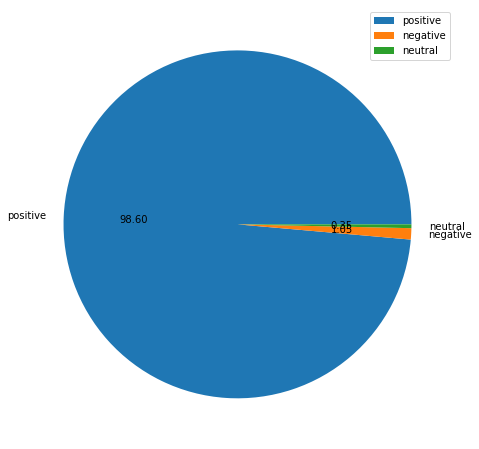

In [21]:
%matplotlib inline
tb_count = data_sociolla['sentiment'].value_counts()
plt.figure(figsize=(10, 8))
plt.pie(tb_count.values, labels=tb_count.index, autopct='%.2f')
plt.legend()

## insert negative sentiment into female daily data set

In [22]:
 data_femaleDaily.loc[-1] = ['jelek banget', 'negative', 0.388924]
 data_femaleDaily.index = data_femaleDaily.index + 1
 data_femaleDaily = data_femaleDaily.sort_index()

## Preview female daily label

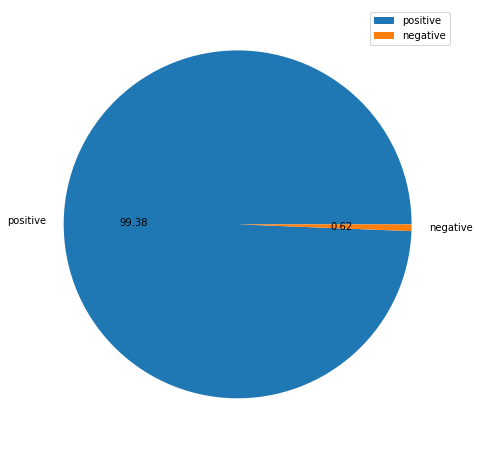

In [23]:
%matplotlib inline
tb_count = data_femaleDaily['sentiment'].value_counts()
plt.figure(figsize=(10, 8))
plt.pie(tb_count.values, labels=tb_count.index, autopct='%.2f')
plt.legend()

## Split data into train and test

In [24]:
train, test = train_test_split(data_sociolla, test_size=0.2, random_state=1)
sociolla_X_train = train['text'].values
sociolla_X_test = test['text'].values
sociolla_Y_train = train['sentiment']
sociolla_Y_test = test['sentiment']

In [25]:
sociolla_train = pd.DataFrame()
sociolla_train['text'] = sociolla_X_train
sociolla_train['sentiment'] = sociolla_Y_train

sociolla_test = pd.DataFrame()
sociolla_test['text'] = sociolla_X_test
sociolla_test['sentiment'] = sociolla_Y_test

In [26]:
train, test = train_test_split(data_femaleDaily, test_size=0.2, random_state=1)
femaleDaily_X_train = train['text'].values
femaleDaily_X_test = test['text'].values
femaleDaily_Y_train = train['sentiment']
femaleDaily_Y_test = test['sentiment']

In [27]:
femaleDaily_train = pd.DataFrame()
femaleDaily_train['text'] = femaleDaily_X_train
femaleDaily_train['sentiment'] = femaleDaily_Y_train

femaleDaily_test = pd.DataFrame()
femaleDaily_test['text'] = femaleDaily_X_test
femaleDaily_test['sentiment'] = femaleDaily_Y_test

## Checkpoint save train & test

In [28]:
sociolla_train.to_json(r'/content/sociolla-train.json')
sociolla_test.to_json(r'/content/sociolla-test.json')

In [29]:
femaleDaily_train.to_json(r'/content/femaleDaily-train.json')
femaleDaily_test.to_json(r'/content/femaleDaily-test.json')

## TFIDF

### Sociolla

In [ ]:
sociolla_TFIDF = TfidfVectorizer()

In [ ]:
sociolla_TFIDF.fit(data_sociolla['text'])
sociolla_train_tfidf = sociolla_TFIDF.transform(sociolla_train['text'])
sociolla_test_tfidf = sociolla_TFIDF.transform(sociolla_test['text'])

In [ ]:
print(sociolla_TFIDF.vocabulary_)

### Female daily

In [ ]:
femaleDaily_TFIDF = TfidfVectorizer()

In [ ]:
femaleDaily_TFIDF.fit(data_femaleDaily['text'])
femaleDaily_train_tfidf = femaleDaily_TFIDF.transform(femaleDaily_train['text'])
femaleDaily_test_tfidf = femaleDaily_TFIDF.transform(femaleDaily_test['text'])

In [ ]:
print(femaleDaily_TFIDF.vocabulary_)

## SVM analysis

### Sociolla

#### Model

In [33]:
sociolla_model = SVC(kernel='linear', probability=True)
sociolla_model.fit(sociolla_train_tfidf, sociolla_Y_train)

SVC(kernel='linear', probability=True)

#### Accuracy

In [66]:
sociolla_predictions_SVM = sociolla_model.predict(sociolla_test_tfidf)
sociolla_test_prediction = pd.DataFrame()
sociolla_test_prediction['text'] = sociolla_X_test
sociolla_test_prediction['sentiment'] = sociolla_predictions_SVM
sociolla_SVM_accuracy = accuracy_score(sociolla_predictions_SVM, sociolla_Y_test) * 100
sociolla_SVM_accuracy = round(sociolla_SVM_accuracy, 1)

In [69]:
sociolla_SVM_accuracy

99.0

In [65]:
print("\nHere is the classification report:") 
print(classification_report(sociolla_Y_test, sociolla_predictions_SVM))


Here is the classification report:
              precision    recall  f1-score   support

    negative       0.00      0.00      0.00         3
     neutral       0.20      0.50      0.29         2
    positive       0.99      0.99      0.99       511

    accuracy                           0.98       516
   macro avg       0.40      0.50      0.43       516
weighted avg       0.98      0.98      0.98       516



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Female daily

#### Model

In [40]:
femaleDaily_model = SVC(kernel='linear', probability=True)
femaleDaily_model.fit(femaleDaily_train_tfidf, femaleDaily_Y_train)

SVC(kernel='linear', probability=True)

#### Accuracy

In [41]:
femaleDaily_predictions_SVM = femaleDaily_model.predict(femaleDaily_test_tfidf)
femaleDaily_test_prediction = pd.DataFrame()
femaleDaily_test_prediction['text'] = femaleDaily_X_test
femaleDaily_test_prediction['sentiment'] = femaleDaily_predictions_SVM
femaleDaily_SVM_accuracy = accuracy_score(femaleDaily_predictions_SVM, femaleDaily_Y_test) * 100
femaleDaily_SVM_accuracy = round(femaleDaily_SVM_accuracy, 1)

In [50]:
femaleDaily_SVM_accuracy

100.0

In [43]:
print("\nHere is the classification report:") 
print(classification_report(femaleDaily_Y_test, femaleDaily_predictions_SVM))


Here is the classification report:
              precision    recall  f1-score   support

    positive       1.00      1.00      1.00        33

    accuracy                           1.00        33
   macro avg       1.00      1.00      1.00        33
weighted avg       1.00      1.00      1.00        33



## Naive bayes analysis

### Sociolla

#### Model

In [70]:
sociolla_cnb_model = ComplementNB()
sociolla_cnb_model.fit(sociolla_train_tfidf, sociolla_Y_train)

ComplementNB()

#### Accuracy

In [79]:
sociolla_predictions_Naive = sociolla_cnb_model.predict(sociolla_test_tfidf)
sociolla_test_prediction = pd.DataFrame()
sociolla_test_prediction['text'] = sociolla_X_test
sociolla_test_prediction['sentiment'] = sociolla_predictions_Naive
sociolla_Naive_accuracy = accuracy_score(sociolla_predictions_Naive, sociolla_Y_test) * 100
sociolla_Naive_accuracy = round(sociolla_Naive_accuracy, 1)

In [81]:
sociolla_Naive_accuracy

98.4

In [82]:
print("\nHere is the classification report:") 
print(classification_report(sociolla_Y_test, sociolla_predictions_Naive))


Here is the classification report:
              precision    recall  f1-score   support

    negative       0.00      0.00      0.00         3
     neutral       0.20      0.50      0.29         2
    positive       0.99      0.99      0.99       511

    accuracy                           0.98       516
   macro avg       0.40      0.50      0.43       516
weighted avg       0.98      0.98      0.98       516



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Female daily

#### Model

In [84]:
femaleDaily_cnb_model = ComplementNB()
femaleDaily_cnb_model.fit(femaleDaily_train_tfidf, femaleDaily_Y_train)

ComplementNB()

#### Accuracy

In [85]:
femaleDaily_predictions_Naive = femaleDaily_cnb_model.predict(femaleDaily_test_tfidf)
femaleDaily_test_prediction = pd.DataFrame()
femaleDaily_test_prediction['text'] = femaleDaily_X_test
femaleDaily_test_prediction['sentiment'] = femaleDaily_predictions_Naive
femaleDaily_Naive_accuracy = accuracy_score(femaleDaily_predictions_Naive, femaleDaily_Y_test) * 100
femaleDaily_Naive_accuracy = round(femaleDaily_Naive_accuracy, 1)

In [86]:
femaleDaily_Naive_accuracy

100.0

In [87]:
print("\nHere is the classification report:") 
print(classification_report(femaleDaily_Y_test, femaleDaily_predictions_Naive))


Here is the classification report:
              precision    recall  f1-score   support

    positive       1.00      1.00      1.00        33

    accuracy                           1.00        33
   macro avg       1.00      1.00      1.00        33
weighted avg       1.00      1.00      1.00        33



## Conclusion

### Sociolla

In [93]:
def top_words(data):
  words_list = data.split(' ')
  counts = Counter(words_list)
  top_words = counts.most_common(20)
  length_of_list = len(top_words)
  index = np.arange(length_of_list)
  print(top_words)
  count_values = [x[1] for x in top_words]
  count_words = [x[0] for x in top_words]
  fig = plt.figure(figsize = (16,9))
  bar_width = 0.4
  rects1 = plt.bar(index, count_values)
  plt.xticks(index + bar_width, count_words, rotation=0)
  plt.show()

Top words in Positive Sentiment
[('dan', 2857), ('banget', 2799), ('ini', 2666), ('aku', 2363), ('sunscreen', 2270), ('kulit', 1672), ('di', 1618), ('yang', 1427), ('juga', 1297), ('ga', 1292), ('jadi', 1167), ('buat', 1074), ('suka', 1056), ('bikin', 1034), ('sama', 994), ('nya', 973), ('npure', 971), ('wajah', 959), ('produk', 906), ('yg', 844)]


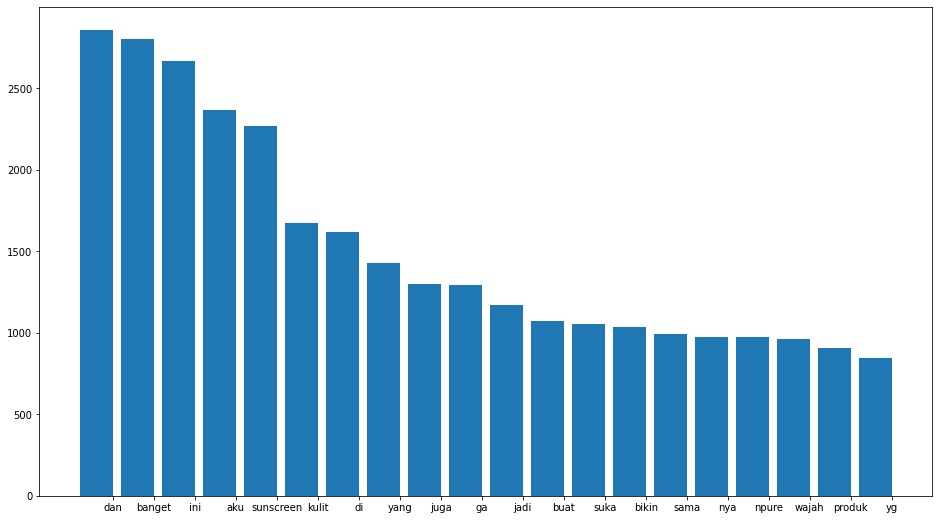

In [94]:
sociolla_positive_sentiment = data_sociolla[data_sociolla['sentiment'] == 'positive']
positive_words = ' '.join(sociolla_positive_sentiment['text'])
print("Sociolla Top words in Positive Sentiment")
top_words(positive_words)

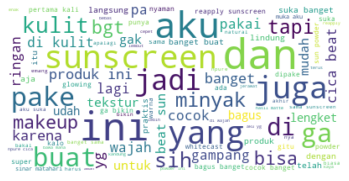

In [98]:
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(positive_words)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

### Female daily

Female Daily Top words in Positive Sentiment
[('ini', 204), ('banget', 198), ('dan', 178), ('aku', 172), ('sunscreen', 138), ('di', 132), ('kulit', 126), ('buat', 100), ('ga', 100), ('juga', 98), ('yang', 94), ('powder', 78), ('produk', 72), ('jadi', 72), ('suka', 72), ('sama', 70), ('pake', 62), ('bikin', 58), ('wajah', 56), ('cocok', 54)]


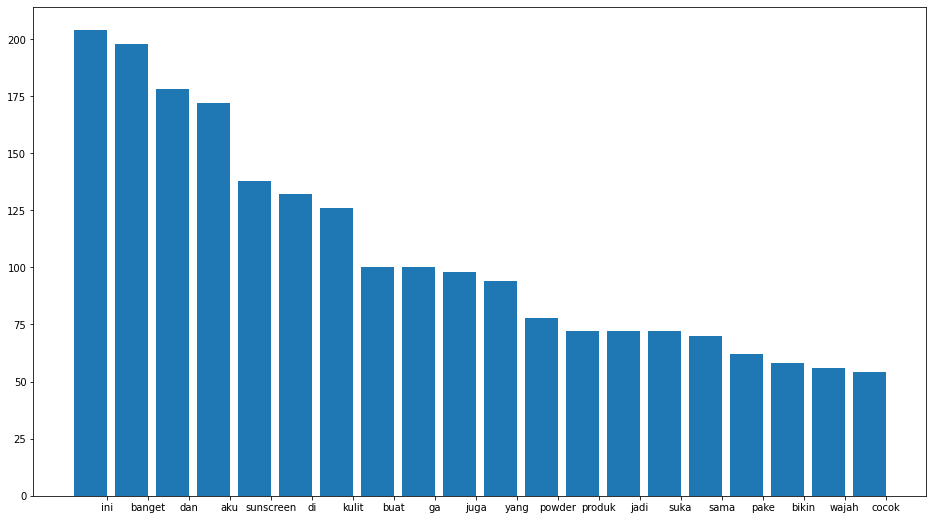

In [99]:
femaleDaily_positive_sentiment = data_femaleDaily[data_femaleDaily['sentiment'] == 'positive']
positive_words = ' '.join(femaleDaily_positive_sentiment['text'])
print("Female Daily Top words in Positive Sentiment")
top_words(positive_words)

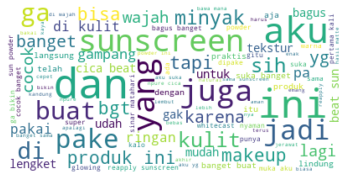

In [100]:
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(positive_words)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

### Accuracy

In [101]:
print(classification_report(sociolla_Y_test, sociolla_predictions_SVM))

              precision    recall  f1-score   support

    negative       0.00      0.00      0.00         3
     neutral       0.20      0.50      0.29         2
    positive       0.99      0.99      0.99       511

    accuracy                           0.98       516
   macro avg       0.40      0.50      0.43       516
weighted avg       0.98      0.98      0.98       516



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [102]:
print(classification_report(femaleDaily_Y_test, femaleDaily_predictions_SVM))

              precision    recall  f1-score   support

    positive       1.00      1.00      1.00        33

    accuracy                           1.00        33
   macro avg       1.00      1.00      1.00        33
weighted avg       1.00      1.00      1.00        33



In [103]:
print(classification_report(sociolla_Y_test, sociolla_predictions_Naive))

              precision    recall  f1-score   support

    negative       0.00      0.00      0.00         3
     neutral       0.20      0.50      0.29         2
    positive       0.99      0.99      0.99       511

    accuracy                           0.98       516
   macro avg       0.40      0.50      0.43       516
weighted avg       0.98      0.98      0.98       516



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [104]:
print(classification_report(femaleDaily_Y_test, femaleDaily_predictions_Naive))

              precision    recall  f1-score   support

    positive       1.00      1.00      1.00        33

    accuracy                           1.00        33
   macro avg       1.00      1.00      1.00        33
weighted avg       1.00      1.00      1.00        33

